# Imports

In [1]:
from pathlib import Path
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize, LightSource

# Get the data

In [2]:
filename = 'COM_CMB_IQU-commander_2048_R3.00_full.fits'
filename_old = 'COM_CompMap_CMB-smica_2048_R1.20.fits'

In [3]:
if not Path(filename).exists():
    !wget https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-commander_2048_R3.00_full.fits
else:
    !echo "{filename} already downloaded"

COM_CMB_IQU-commander_2048_R3.00_full.fits already downloaded


In [4]:
if not Path(filename_old).exists():
    !wget https://irsa.ipac.caltech.edu/data/Planck/release_1/all-sky-maps/maps/COM_CompMap_CMB-smica_2048_R1.20.fits
else:
    !echo "{filename_old} already downloaded"

COM_CompMap_CMB-smica_2048_R1.20.fits already downloaded


In [5]:
cmap_file = 'Planck_Parchment_RGB.txt'
if not Path(cmap_file).exists():
    !wget https://raw.githubusercontent.com/zonca/paperplots/master/data/Planck_Parchment_RGB.txt
else:
    !echo "{cmap_file} already downloaded"

Planck_Parchment_RGB.txt already downloaded


# Read in data

In [6]:
cmb_map = hp.read_map(filename, ('I_STOKES_INP',))

In [7]:
planck_cmap_data = np.loadtxt(cmap_file)

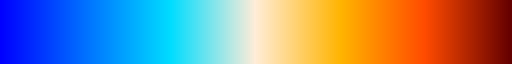

In [8]:
planck_cmap = ListedColormap(planck_cmap_data/255.)
planck_cmap.set_bad("gray")
planck_cmap.set_under("#00000000")
cmap = planck_cmap
cmap

In [ ]:
w, h, dpi = 60, 40, 300
fig = plt.figure(figsize=(w, h), dpi=dpi)

In [ ]:
hp.mollview(cmb_map, fig=fig.number, xsize=w*dpi, min=-1e0, max=1e0, title=r"CMB $\Delta$ T", unit="K", cmap=cmap,
            bgcolor="#00000000")
plt.savefig("cmb2D_1e0.png", transparent=True, bbox_inches="tight")

In [ ]:
plt.clf()

In [ ]:
w, h, dpi = 60, 40, 300
fig = plt.figure(figsize=(w, h), dpi=dpi)

In [ ]:
hp.mollview(cmb_map, fig=fig.number, xsize=w*dpi, min=-5e-4, max=5e-4, title=r"CMB $\Delta$ T", unit="K", cmap=cmap,
            bgcolor="#00000000")
plt.savefig("cmb2D_1e-4.png", transparent=True, bbox_inches="tight")

In [ ]:
plt.clf()
plt.close()

# Map onto spherical surface in 3D

In [ ]:
def hp_3dsphere(ax, data, r=1.0,
                min=None, max=None,
                cmap=None, norm=None, alpha=None,
                shade=False, lightsource=False, antialiased=False,
                **kwargs):
    """
    Plot a healpix map onto spherical surface in 3D
    """
    data = np.asanyarray(data)
    *nmaps, npix = data.shape
    nside = hp.npix2nside(npix)
    r = np.broadcast_to(r, nmaps)

    if cmap is None:
        cm = plt.cm.get_cmap('RdYlBu_r')
    elif isinstance(cmap, str):
        cm = plt.cm.get_cmap(cmap)
    else:
        cm = cmap
    if norm is None:
        norm = Normalize(vmin=min, vmax=max)
    if alpha is None:
        alpha = np.full(nmaps, None)
    else:
        alpha = np.broadcast_to(alpha, nmaps)
    if isinstance(lightsource, LightSource):
        ls = lightsource
    elif lightsource:
        ls = LightSource(azdeg=0, altdeg=30)
    else:
        ls = None

    out = np.empty(nmaps, dtype=object)
    for i in np.ndindex(*nmaps):
        pix = np.where(data[i] != hp.UNSEEN)[0]

        ver = np.empty((4*len(pix), 3))
        tri = np.empty((2*len(pix), 3), dtype=int)
        for j, p in enumerate(pix):
            ver[4*j:4*(j+1)] = r[i]*hp.boundaries(nside, p, 1).T
            tri[2*j:2*(j+1)] = [[4*j, 4*j+1, 4*j+3], [4*j+1, 4*j+2, 4*j+3]]

        surf = ax.plot_trisurf(ver[:, 0], ver[:, 1], ver[:, 2], triangles=tri, alpha=alpha[i],
                               lightsource=ls, shade=shade, antialiased=antialiased,
                               **kwargs)
        col = cm(norm(data[i][pix]))
        surf.set_fc(np.repeat(col, 2, axis=0))
        surf.set_ec('none')
        surf.set_lw(0)

        out[i] = surf

    if not nmaps:
        out = out.item()

    return out

In [ ]:
cmb_map_lowres = hp.ud_grade(cmb_map, 256)

In [ ]:
w, h, dpi = 60, 40, 100
fig = plt.figure(figsize=(w, h), dpi=dpi)
ax = fig.add_subplot(111, projection='3d')
hp_3dsphere(ax, cmb_map_lowres, vmin=-1e-4, vmax=1e-4, cmap=planck_cmap,
            antialiased=True, shade=True, lightsource=False)
ax.set_axis_off()
for angle in range(352, 360):
    angle_norm = (angle + 180) % 360 - 180
    ax.view_init(0, angle_norm, 0)
    # plt.draw()
    plt.savefig(f"cmb3D_1e-4_{angle}.png", transparent=True, bbox_inches='tight')
plt.close()

In [ ]:
w, h, dpi = 60, 40, 100
fig = plt.figure(figsize=(w, h), dpi=dpi)
ax = fig.add_subplot(111, projection='3d')
hp_3dsphere(ax, cmb_map_lowres, vmin=-1, vmax=1, cmap=planck_cmap,
            antialiased=True, shade=True, lightsource=False)
ax.set_axis_off()
plt.savefig(f"cmb3D_1e0_{angle}.png", transparent=True, bbox_inches='tight')
plt.close()

# Uniform 3D sphere

In [22]:
u = np.linspace(0, 2*np.pi, 300)
v = np.linspace(0, np.pi, 300)
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
print(x.shape, y.shape, z.shape)

(300, 300) (300, 300) (300, 300)


In [23]:
ls = LightSource(azdeg=120, altdeg=30)
rgb = np.tile(np.array(cmap(0.5)), (z.shape[0], z.shape[1], 1))
rgb = ls.shade_rgb(rgb, z, fraction=0.9, blend_mode='soft')

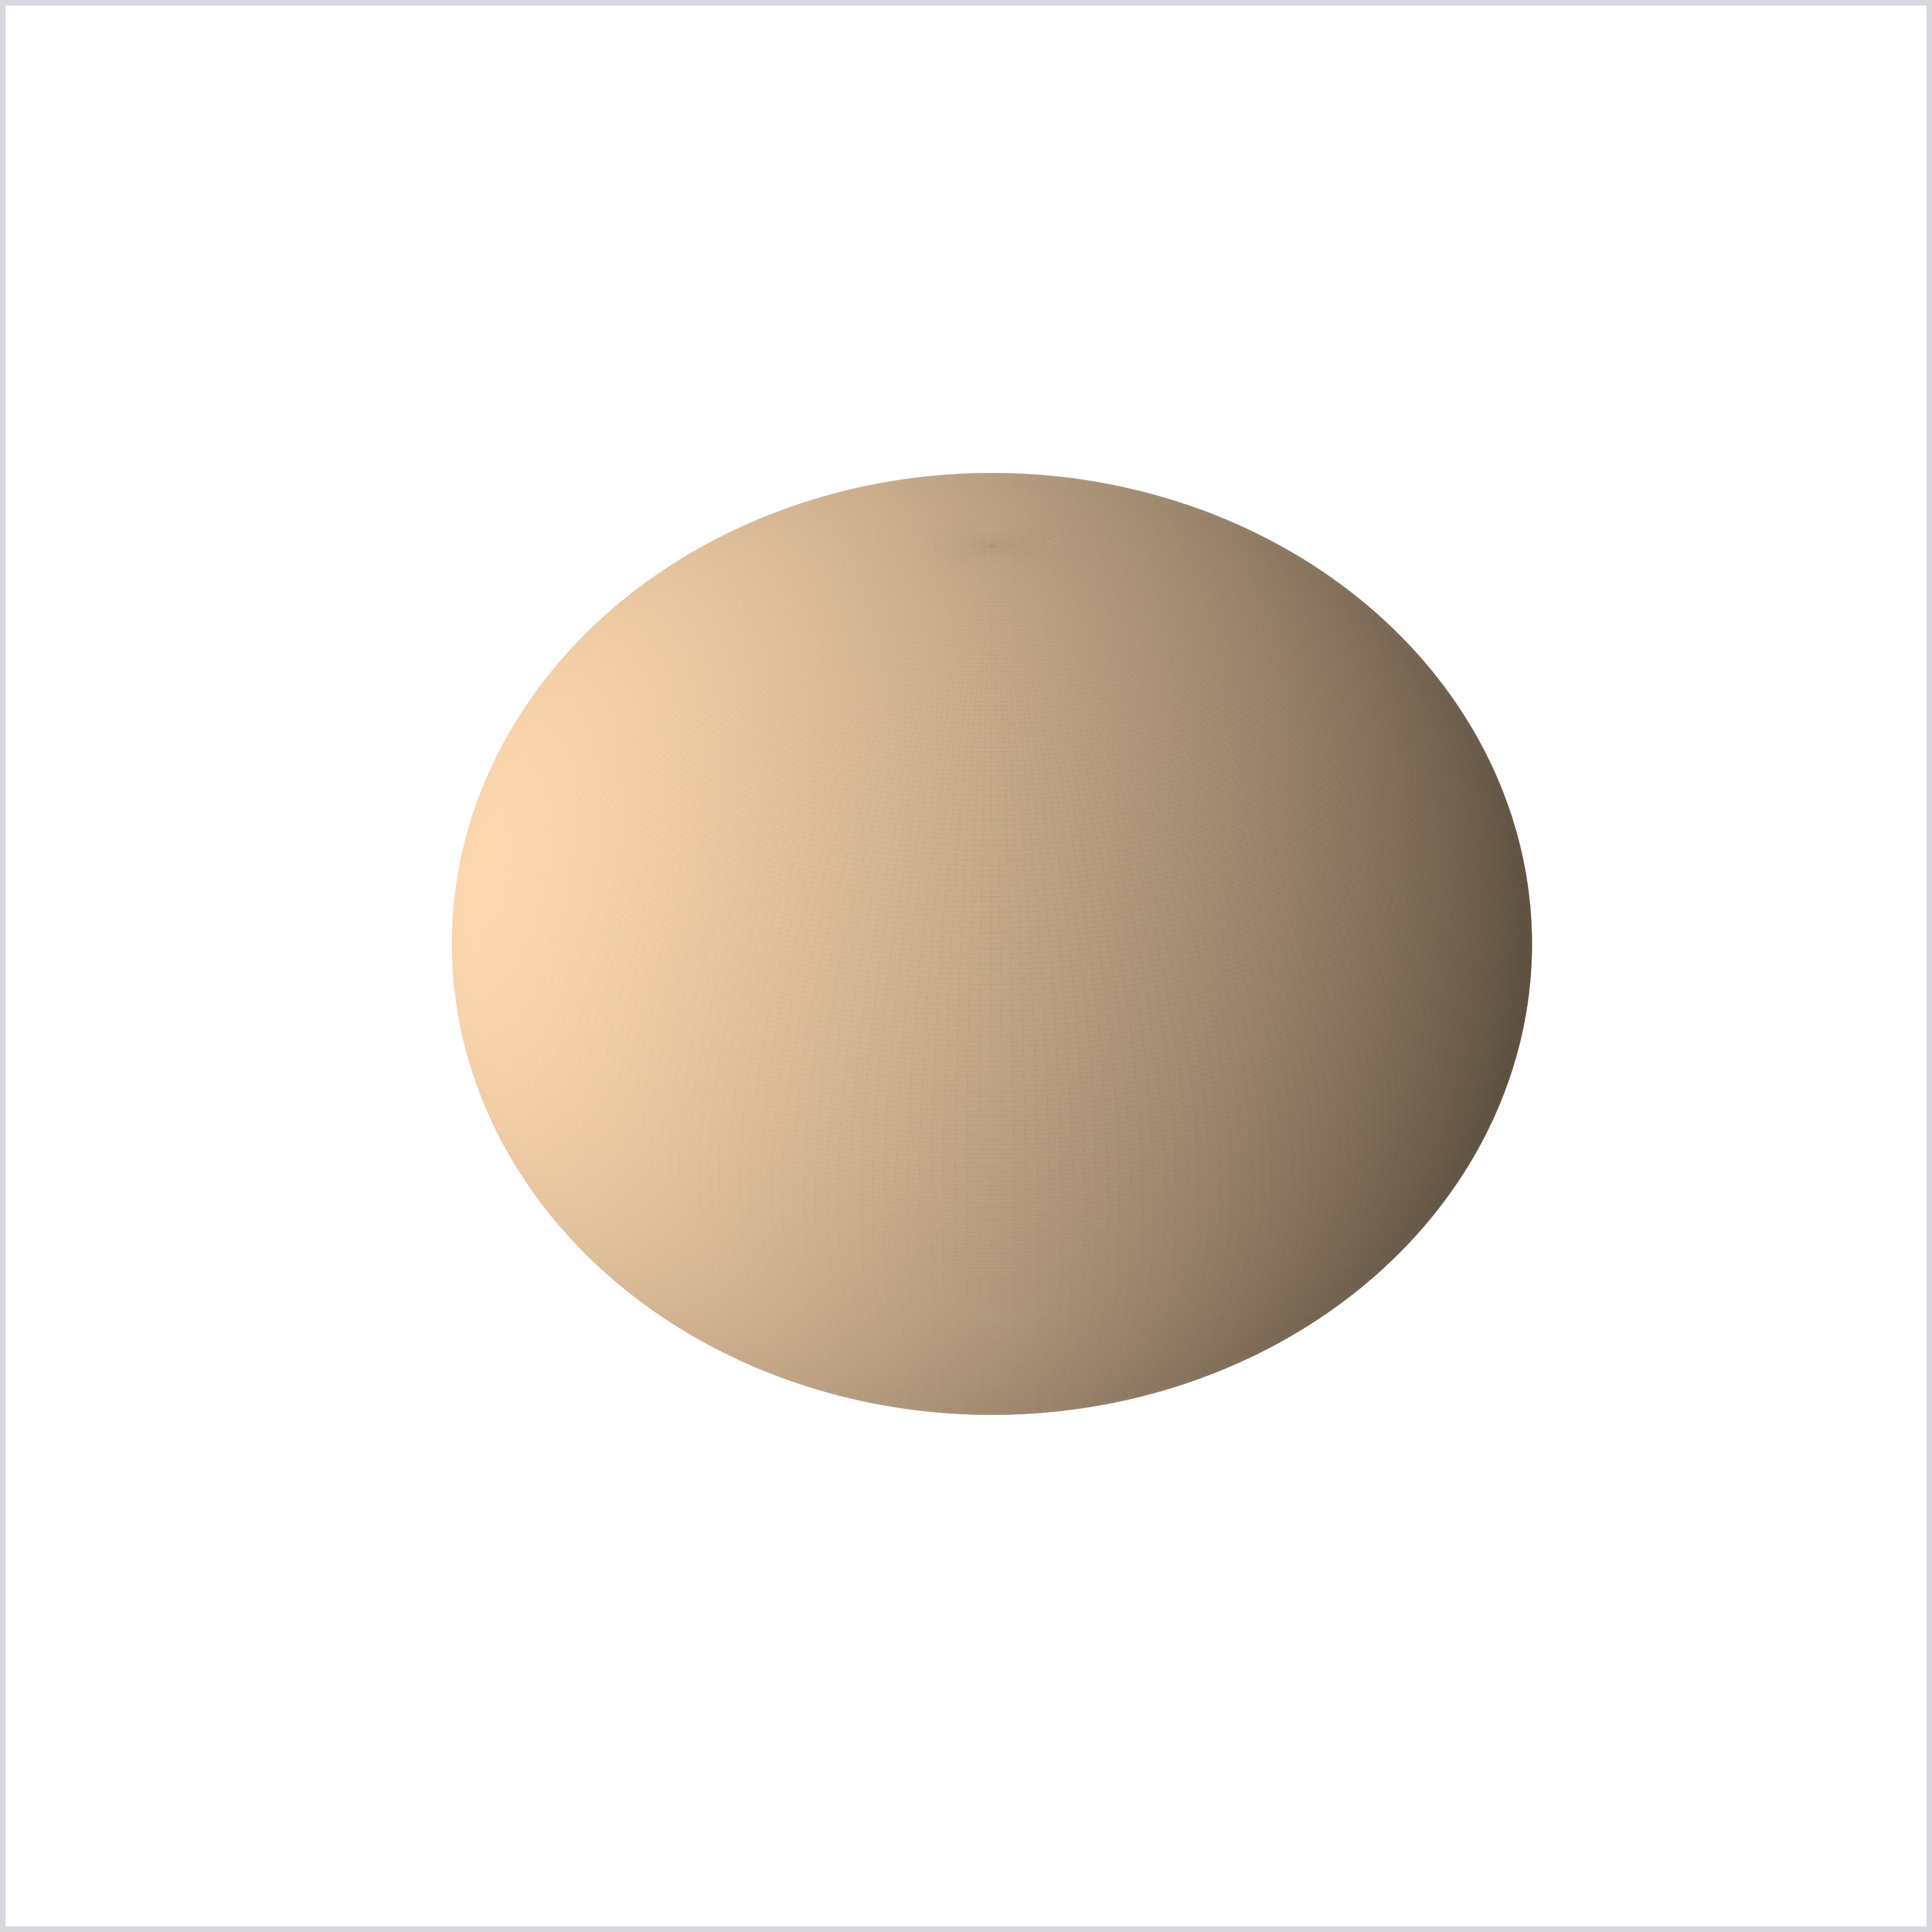

In [24]:
w, h, dpi = 60, 40, 100
fig = plt.figure(figsize=(w, h), dpi=dpi)
ax = fig.add_subplot(111, projection='3d')
ax.set_axis_off()
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb, linewidth=0,
                alpha=0.95, antialiased=True)
# plt.draw()
plt.savefig(f"cmb3D_1e0.png", transparent=True, bbox_inches='tight')